<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/BaggingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you

---
# Manual ensembling

What makes a good manual ensemble?

- Different types of **models**
    - Ex. Build an SVC, Decision Tree and a kNN
- Different combinations of **features**
    - Ex. Take a random selection of 5 variables for each model
- Different **tuning parameters**
    - Ex. From the grid search take the top 5 or ten best performing models

---
## Comparing manual ensembling with a single model approach

**Advantages of manual ensembling:**

- Increases predictive accuracy
- Easy to get started

**Disadvantages of manual ensembling:**

- Decreases interpretability
- Takes longer to train
- Takes longer to predict
- More complex to automate and maintain
- Small gains in accuracy may not be worth the added complexity

---
**Decision Trees are a**

    - LOW BIAS (not prone to underfitting), 
    - HIGH VARIANCE (prone to overfitting) algorithm


- ENSEMBLES are a variance reduction technique

- ENSEMBLES OF DECISION TREES create LOW BIAS, LOW VARIANCE model.

---
# Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

**bootstrap sample:** A random sample with replacement.

---
**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import sklearn.tree as dt
import sklearn.ensemble as en

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

import pydotplus as pdot
from IPython.display import Image

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/HR_comma_sep.csv'

<Figure size 720x540 with 0 Axes>

In [0]:
hr_df = pd.read_csv(url)

In [20]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [0]:
# now we need to create dummy variables for categorical variables(dtype=object)
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project',
     'average_montly_hours', 'time_spend_company']

categorical_features = ['Work_accident','promotion_last_5years', 'department', 'salary']

In [22]:
categorical_features

['Work_accident', 'promotion_last_5years', 'department', 'salary']

In [23]:
numerical_features

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company']

In [0]:
# A utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [25]:
for c_feature in categorical_features:
    hr_df = create_dummies( hr_df, c_feature )

hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [26]:
#Splitting the data

feature_columns = hr_df.columns.difference( ['left'] )
feature_columns

Index(['Work_accident_1', 'average_montly_hours', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'last_evaluation',
       'number_project', 'promotion_last_5years_1', 'salary_low',
       'salary_medium', 'satisfaction_level', 'time_spend_company'],
      dtype='object')

### Test Train split

In [0]:
train_X, test_X, train_y, test_y = train_test_split( hr_df[feature_columns],
                                                  hr_df['left'],
                                                  test_size = 0.3,
                                                  random_state = 42 )

In [28]:
bagcls = BaggingClassifier(oob_score=True, n_estimators=100)
bagcls.fit(train_X, train_y)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=100,
                  n_jobs=None, oob_score=True, random_state=None, verbose=0,
                  warm_start=False)

In [0]:
y_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': bagcls.predict( test_X) } )

In [30]:
bagcls.estimators_features_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0

In [31]:
metrics.accuracy_score(y_pred.actual, y_pred.predicted)

0.986

## Creating confusion matrix for bagging tree

Text(0.5, 46.5, 'Predicted label')

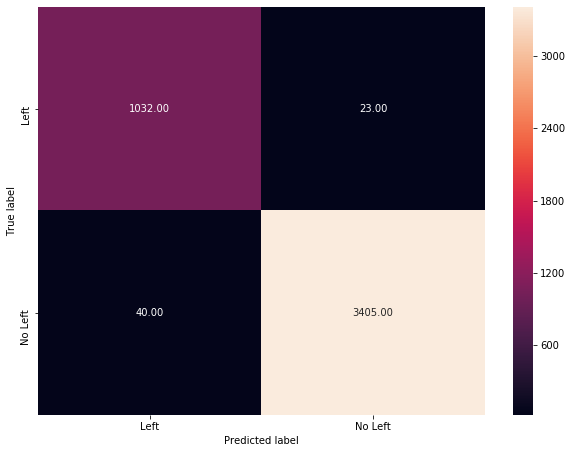

In [33]:
tree_bg = metrics.confusion_matrix( y_pred.predicted,
                                 y_pred.actual,
                                 [1,0] )
sns.heatmap(tree_bg, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

----
## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [34]:
# compute the out-of-bag accuracy
bagcls.oob_score_

0.9888560815315744

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees